#### The purpose of this EDA notebook is the following:
- Better understand the nature of the relationship between the independent variables
- Create an initial model with reasonable economic assumptions that may be dropped in later versions
- Explore methods of imputation for missing variables to provide more data samples
- Avoid linear combinations that might be more difficult to spot in the Bayesian Modeling process
- Establish a reasonable measure of variable importance, which along with correlation plots may inform initial hierarchies
- Create visualizations of poor quality data and also establish probability distributions for the likelihood function

#### 1. Import data and necessary packages

In [1]:
import os

# os.environ['KERAS_BACKEND'] = 'theano'
# os.environ['THEANO_FLAGS']='cpu'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import arviz as az
import pymc3 as pm
import theano
import theano.tensor as tt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
# import category_encoders as ce
import shap
import mkl
import xarray
from statsmodels.stats.outliers_influence import variance_inflation_factor
from fitter import Fitter, get_common_distributions, get_distributions
from pymc3.variational.callbacks import CheckParametersConvergence

# %load_ext timeit
# %load_ext heat
# %load_ext line_profiler
# %load_ext memory_profiler

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\norri\.conda\envs\mercury-ds\lib\site-packages\torch\_masked\__init__.py:223: UserWarning: Failed to initialize NumPy: module compiled against API version 0xf but this version of numpy is 0xe (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:68.)
  example_input = torch.tensor([[-3, -2, -1], [0, 1, 2]])


In [2]:
df = pd.read_csv('G:/My Drive/To_Do/IN_DS/cortex_Push.csv')
df_bu = df

In [3]:
df = df.drop(['Program Name', 'Retailers', 'Tactic', 'Vendor', 'Tactic Start Date',
              'Tactic End Date'], axis=1)
segment = [var for var in df.columns if df[var].dtype == 'O']
df_cat = df.select_dtypes(include=object)
# print(df_cat.nunique())

In [4]:
df.RMN.replace(('Yes', 'No'), (1, 0), inplace=True)

In [5]:
# for col in df.select_dtypes(include='object'):
#     if df[col].nunique() <= 25:
#         sns.countplot(y=col, data=df)
#         plt.show()

In [6]:
# df = df.drop(
#     [], axis=1)
integer = [var for var in df.columns if df[var].dtype == 'int64']
df_int = df.select_dtypes(include=int)

In [7]:
df = df.drop(
        ['Base $', 'Incr $', 'Base Units', 'Incr Units',
         '$ Shr - Ty Subcategory', 'Units Shr - Ty Category',
         'Units Shr - Ty Subcategory'], axis=1)
fp = [var for var in df.columns if df[var].dtype == 'float64']
fp_na = df[fp].isnull().sum() / len(df) * 100
fp_zero = df[fp].sum()

In [8]:
df = df.drop(
        ['ClientId', 'Program Id', 'TacticId', 'CategoryId',
         'BrandId', 'Nielsen_Week_Year', 'VendorId'], axis=1)
df_num = df.select_dtypes(exclude='object')
# df_num.describe()

In [9]:
final_vars_cat = ['Number of UPCs Selling', 'Any Promo Units', '%ACV Distribution',
                  'Feat w/o Disp %ACV', 'Price Decr Only %ACV', 'Disp w/o Feat %ACV',
                  'Total Sales', 'Feat & Disp %ACV', 'RMN', 'Tactic Category', 'Brand']

final_vars = ['Number of UPCs Selling', 'Any Promo Units', '%ACV Distribution',
              'Feat w/o Disp %ACV', 'Price Decr Only %ACV', 'Disp w/o Feat %ACV',
              'Total Sales', 'Feat & Disp %ACV', 'RMN']

In [10]:
df_final = df[final_vars]

dist_list = ['gamma', 'expon', 'cauchy', 'norm', 'uniform']

for var in final_vars:
    dist_test = df_final[var].dropna()
    dist_test = dist_test.values
    f = Fitter(dist_test, distributions=dist_list, timeout=60)
    f.fit()
    print(var)
    print(f.summary(plot=False))
    print(f.get_best(method='sumsquare_error'))

Number of UPCs Selling
         sumsquare_error          aic            bic  kl_div
gamma           0.013375  1075.968649 -292293.237680     inf
expon           0.014814  1063.437196 -290205.813534     inf
cauchy          0.016145  1186.153183 -288439.471614     inf
norm            0.025284  1165.841763 -279234.115072     inf
uniform         0.035964   887.768122 -272003.307866     inf
{'gamma': {'a': 1.1546879907984438, 'loc': -0.0074750016901030895, 'scale': 14.500983104854907}}
Any Promo Units
         sumsquare_error           aic            bic  kl_div
cauchy      2.123850e-11  3.745221e+03 -708116.143728     inf
expon       1.891835e-10  5.644774e+03 -663234.352935     inf
norm        6.276788e-10  7.341008e+03 -638620.889651     inf
uniform     7.617030e-10  2.913060e+03 -634649.112487     inf
gamma       7.849363e-10  6.428922e+07 -634022.551167     NaN
{'cauchy': {'loc': 9127.707279836573, 'scale': 13423.69390246777}}
%ACV Distribution
         sumsquare_error          aic    

In [11]:
df_final_cat = df_bu[final_vars_cat]
df_final_cat = df_final_cat[df_final_cat['Total Sales'] > 0.0]

print('Original number of obs and Tactic Categories')
print(df['Tactic Category'].count())
print(df['Tactic Category'].nunique())

Original number of obs and Tactic Categories
54039
20


In [12]:
print('Number of obs, new tactics, and new displays')
print(df_final_cat['Tactic Category'].count())
print(df_final_cat['Tactic Category'].nunique())
print(df_final_cat['Brand'].nunique())

Number of obs, new tactics, and new displays
20481
18
46


In [13]:
tt.config.floatX = 'float32'

df_final_cat = df_bu[final_vars_cat]
df_final_cat = df_final_cat[df_final_cat['Total Sales'] > 0.0]

df_final_cat['Total Sales'] = np.log(df_final_cat['Total Sales'])

price_decr_idxs, price_decr = pd.factorize(df_final_cat['Price Decr Only %ACV'],
                                           sort=True)
tactic_idxs, tactics = pd.factorize(df_final_cat['Tactic Category'], sort=True)
brand_idxs, brand = pd.factorize(df_final_cat['Brand'], sort=True)
coords = {"tactics": tactics, 'brand': brand, 'obs_idx': np.arange(len(tactic_idxs)), 'price_decrease': price_decr}

#### 3. Hierarchical Model with diagnostics

In [14]:
%%timeit

with pm.Model(coords=coords) as h_model:
    tactic_idx = pm.Data("Tactic Category", tactic_idxs, dims="obs_idx")
    brand_idx = pm.Data("Brand", brand_idxs, dims="obs_idx")
    price_decr = pm.Data("Price Decrease Only", price_decr_idxs, dims="obs_idx")

    # Tactic Category hyperpriors parameters:
    hp_b_0 = pm.Normal("hp_b_0", mu=0.0, sigma=5.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    hp_b_1 = pm.Normal("hp_b_1", mu=0.0, sigma=1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5)

    # Brand hyperpriors parameters
    hp_b_2 = pm.Normal("hp_b_2", mu=0.0, sigma=5.0)
    sigma_c = pm.Exponential("sigma_c", 1.0)
    hp_b_3 = pm.Normal("hp_b_3", mu=0.0, sigma=1.0)
    sigma_d = pm.Exponential("sigma_d", 0.5)

    hp_b_4 = pm.Normal("hp_b_4", mu=0.5, sigma=.3)

    # estimates of independent intercepts and interactions of intercepts
    b_0 = pm.Normal("tactic_int", mu=hp_b_0, sigma=sigma_a, dims="tactics")
    b_1 = pm.Normal("tactic_slope", mu=hp_b_1, sigma=sigma_b, dims="tactics")

    b_2 = pm.Normal("display_int", mu=hp_b_2, sigma=sigma_c, dims="brand")
    b_3 = pm.Normal("display_slope", mu=hp_b_3, sigma=sigma_d, dims="brand")

    price_decr_est = hp_b_4 * price_decr

    # estimate of total sales using intercepts
    sales_est_1 = b_0[tactic_idx] + b_1[tactic_idx] * brand_idx
    sales_est_2 = b_2[brand_idx] + b_3[brand_idx] * tactic_idx
    sales_est = sales_est_1 + sales_est_2 + price_decr_est

    # Data likelihood
    epsilon = pm.Exponential("noise", 1.0)
    Total_Sales = pm.Normal(
            "Log_Total_Sales", mu=sales_est, sigma=epsilon,
            observed=df_final_cat['Total Sales'], dims="obs_idx")

with h_model:
    h_trace = pm.sample(draws=1500, init='advi+adapt_diag',
                        tune=1500,
                        target_accept=0.995, return_inferencedata=True, max_treedepth=15 )

# with h_model:
#     trace_ppc = pm.sample_posterior_predictive(h_trace, random_seed=0)
#     model_pred = trace_ppc['Log_Total_Sales']

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO:pymc3:Initializing NUTS using advi+adapt_diag...


Convergence achieved at 64200
INFO:pymc3.variational.inference:Convergence achieved at 64200
Interrupted at 64,199 [32%]: Average Loss = 2.4168e+09
INFO:pymc3.variational.inference:Interrupted at 64,199 [32%]: Average Loss = 2.4168e+09
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, display_slope, display_int, tactic_slope, tactic_int, hp_b_4, sigma_d, hp_b_3, sigma_c, hp_b_2, sigma_b, hp_b_1, sigma_a, hp_b_0]
INFO:pymc3:NUTS: [noise, display_slope, display_int, tactic_slope, tactic_int, hp_b_4, sigma_d, hp_b_3, sigma_c, hp_b_2, sigma_b, hp_b_1, sigma_a, hp_b_0]


ValueError: Not enough samples to build a trace.

The Mean Squared Error
0.9189513242378373
Trace Summary and Effective Sample Size
          mean     sd  hdi_3%  hdi_97%
hp_b_0   5.502  3.589  -0.221   13.104
hp_b_1   0.015  0.023  -0.027    0.059
hp_b_2   5.588  3.602  -1.127   12.215
hp_b_3   0.013  0.031  -0.047    0.070
hp_b_4   0.000  0.000   0.000    0.000
...        ...    ...     ...      ...
sigma_a  0.636  0.121   0.430    0.863
sigma_b  0.020  0.004   0.013    0.028
sigma_c  1.954  0.210   1.594    2.366
sigma_d  0.034  0.004   0.026    0.042
noise    0.922  0.005   0.913    0.930

[138 rows x 4 columns]
         mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
hp_b_0       0.185    0.136     378.0     535.0   1.01
hp_b_1       0.001    0.001     748.0    1027.0   1.00
hp_b_2       0.184    0.130     386.0     561.0   1.01
hp_b_3       0.001    0.001     488.0     722.0   1.01
hp_b_4       0.000    0.000    3311.0    2419.0   1.00
...            ...      ...       ...       ...    ...
sigma_a      0.002    0.002    2516.0    

C:\Anaconda\lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (138) in plot_posterior, generating only 40 plots
  warnings.warn(


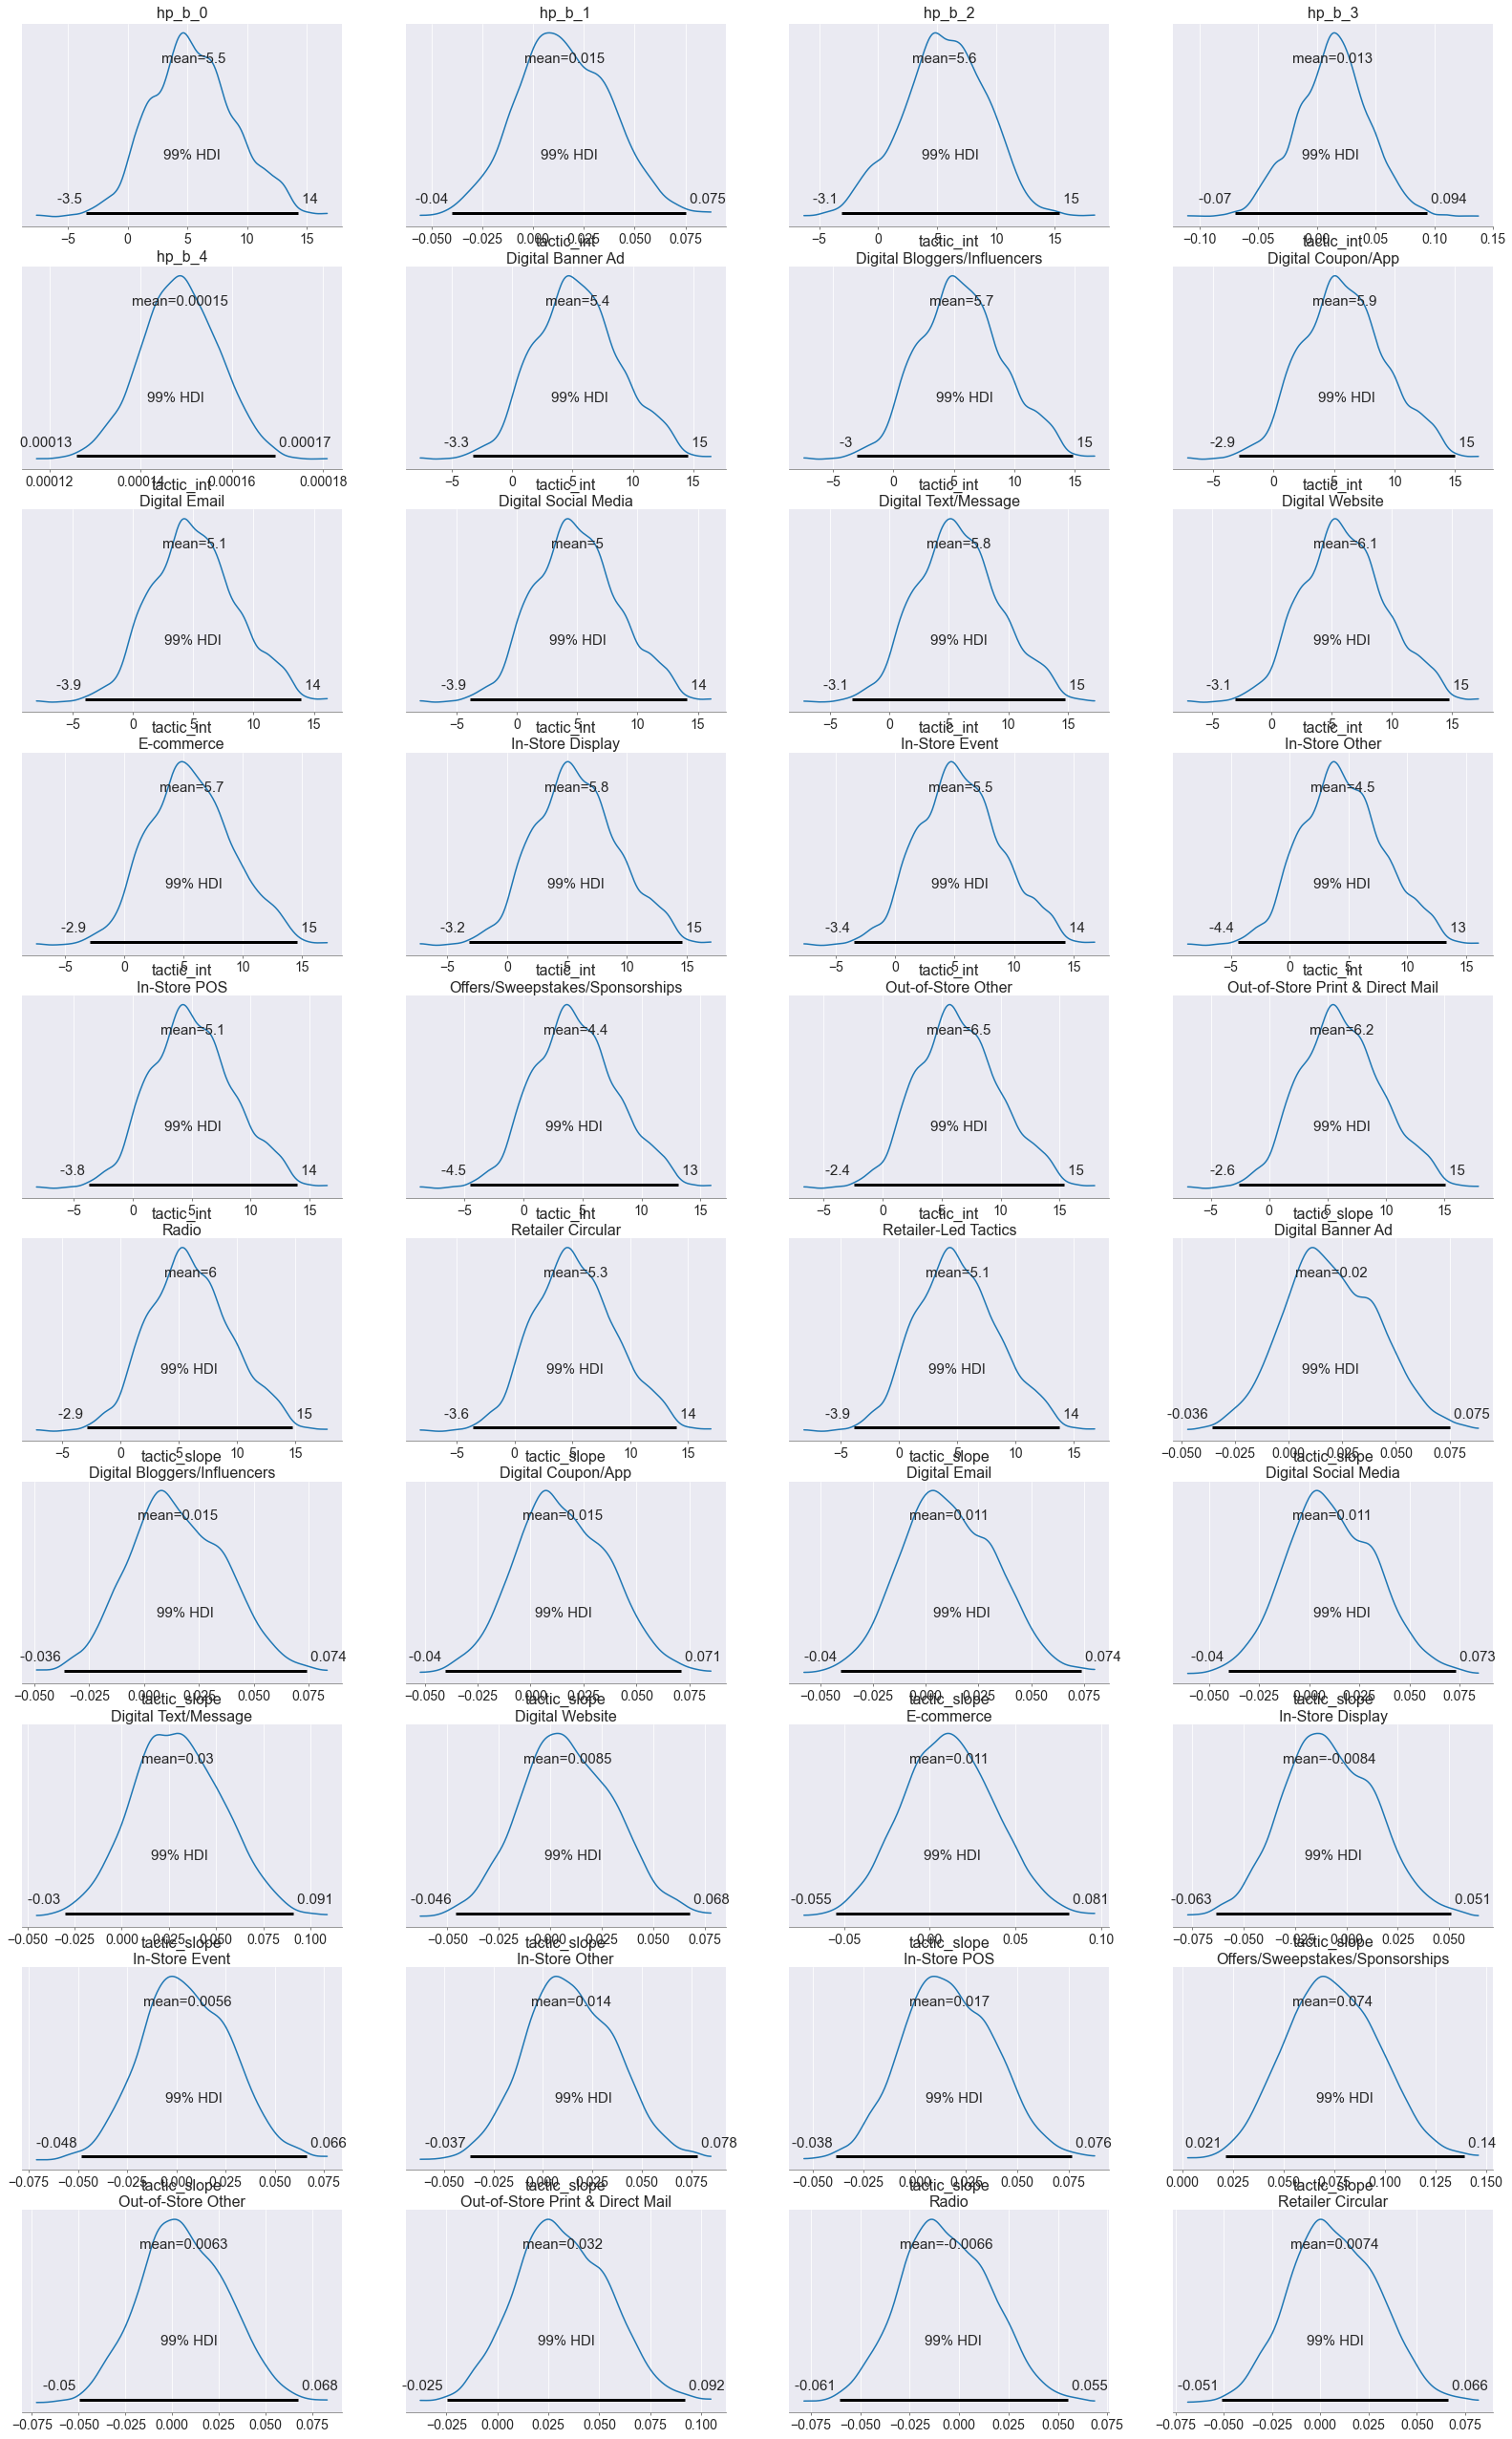

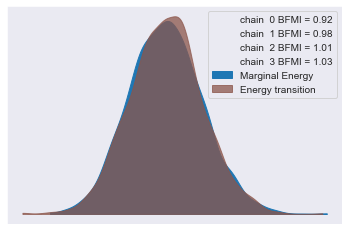

Bayesian fraction of missing information
[0.9169231  0.98189915 1.01473453 1.02900388]


array([<AxesSubplot:>], dtype=object)

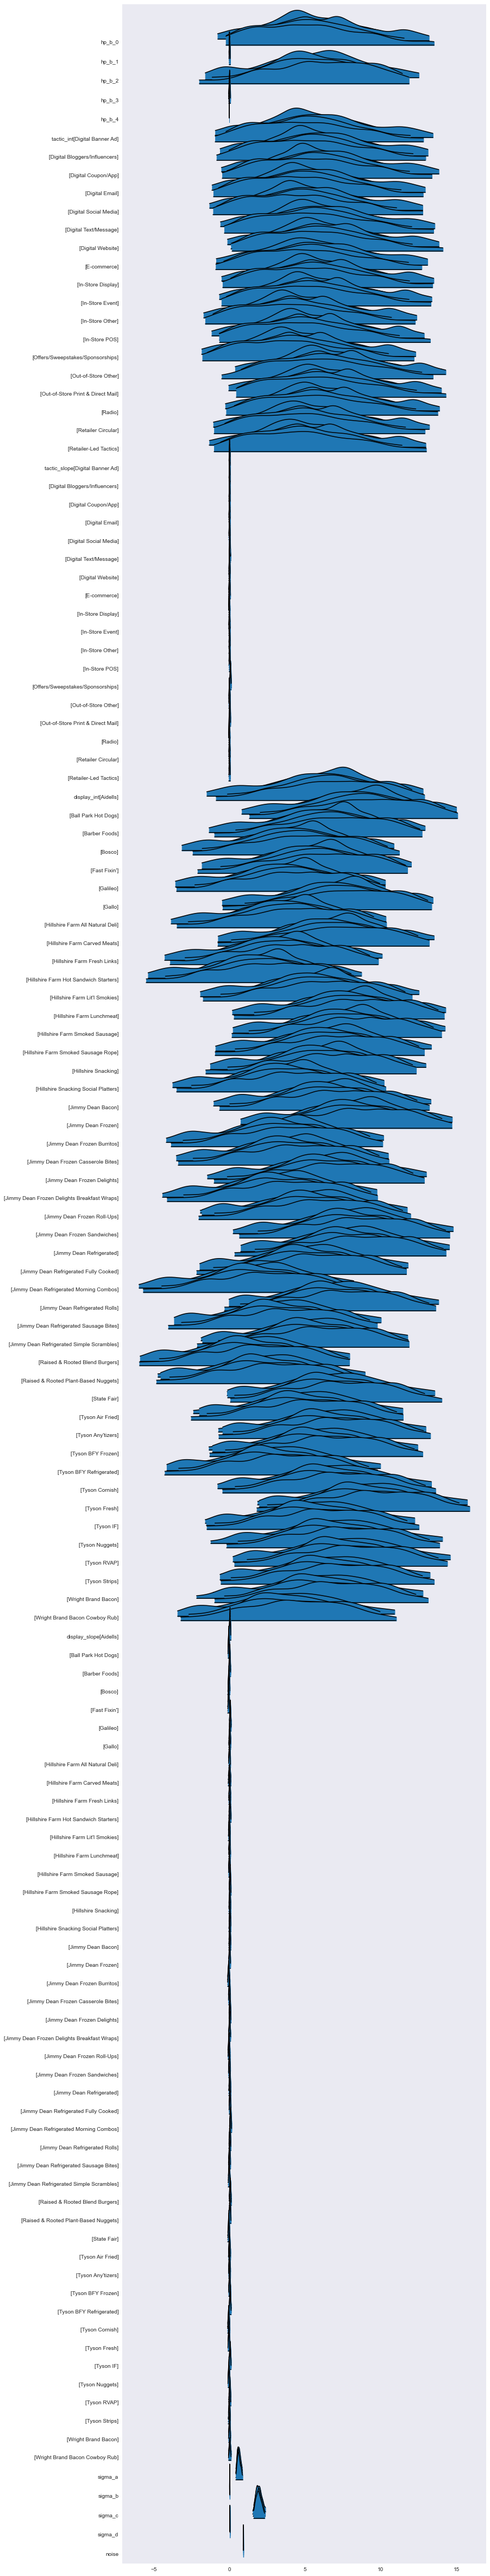

In [72]:
def score_model(trace, y, model_name):
    """

    :param trace: model_trace
    :param y: dependent data column
    :param model_name: model itself
    """
    ppc = pm.sample_posterior_predictive(trace, samples=20841,
                                             model=model_name)
    pred = ppc['Log_Total_Sales'].mean(axis=0)
    mse = np.sqrt(mean_squared_error(y, pred))
    print('The Mean Squared Error')
    print(mse)

score_model(h_trace, df_final_cat['Total Sales'], h_model)

print('Trace Summary and Effective Sample Size')
print(az.summary(h_trace, kind='stats'))
print(az.summary(h_trace, kind='diagnostics'))
az.plot_posterior(h_trace, hdi_prob=0.99)
az.plot_energy(h_trace)
plt.show()
print('Bayesian fraction of missing information')
print(az.bfmi(h_trace))
az.plot_forest(h_trace, kind='ridgeplot')

In [71]:
with h_model:
    trace_ppc = pm.sample_posterior_predictive(h_trace, random_seed=0)
    model_pred = trace_ppc['Log_Total_Sales']

In [ ]:
pm.model_to_graphviz(h_model)